In [1]:
from pathlib import Path
import joblib
import numpy as np
import seaborn as sns
import shap
from scipy import sparse
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils.validation import check_is_fitted

# Definitions

In [2]:
ROOT = Path('..')
MODELS_DIR = ROOT / 'models'
DATA_DIR = ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'

# Load data splits

In [3]:
# TODO: move to utils
def load_data_splits(*, data_dir, split):
    if split not in ['train', 'test']:
        raise ValueError('`split` should be either `train` or `test`')
    
    X = sparse.load_npz(data_dir / split / f'sparse_{split}_X.npz')\
        .toarray()
    y = sparse.load_npz(data_dir / split / f'sparse_{split}_y.npz')\
        .toarray()\
        .squeeze()
    
    return X, y

In [4]:
train_X, train_y = load_data_splits(data_dir=RAW_DATA_DIR, split='train')
test_X, test_y = load_data_splits(data_dir=RAW_DATA_DIR, split='test')

# print shapes to confirm
for split in ['train_X', 'train_y', 'test_X', 'test_y']:
    print('{name}: {shape}'.format(name=split, shape=eval(split).shape))

train_X: (4140, 2048)
train_y: (4140,)
test_X: (1035, 2048)
test_y: (1035,)


# Load best model

In [5]:
best_model_path = MODELS_DIR / 'model_gb.joblib'
model = joblib.load(best_model_path)
check_is_fitted(model)
model

GradientBoostingClassifier(learning_rate=0.3935910935564404, max_depth=14,
                           min_samples_leaf=17, n_estimators=155,
                           random_state=123)

In [6]:
model_tuned_params = dict(
    learning_rate=0.3935911,
    max_depth=14,
    min_samples_leaf=17,
    n_estimators=155,
    random_state=123
)

# Benchmark performance on test set

In [7]:
test_pred = model.predict(test_X)
print('Accuracy on test set: {:.4f}'.format(accuracy_score(test_y, test_pred)))
print(classification_report(test_y, test_pred))

Accuracy on test set: 0.8406
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       324
           1       0.88      0.90      0.89       711

    accuracy                           0.84      1035
   macro avg       0.82      0.81      0.81      1035
weighted avg       0.84      0.84      0.84      1035



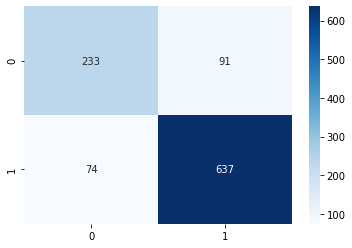

In [8]:
sns.heatmap(confusion_matrix(test_y, test_pred),
            cmap='Blues', annot=True, fmt='d');

# Using SHAP for explanations

In [13]:
def get_top_bits(shap_values, n):
    importances = np.abs(shap_values).mean(0)
    return list(reversed(np.argsort(importances)))[:n]

## On test features

In [9]:
feature_names = [*map(lambda x: 'bit_{}'.format(x),
                      range(test_X.shape[1]))]
explainer = shap.Explainer(model,
                           feature_names=feature_names)
shap_explanation = explainer(train_X)

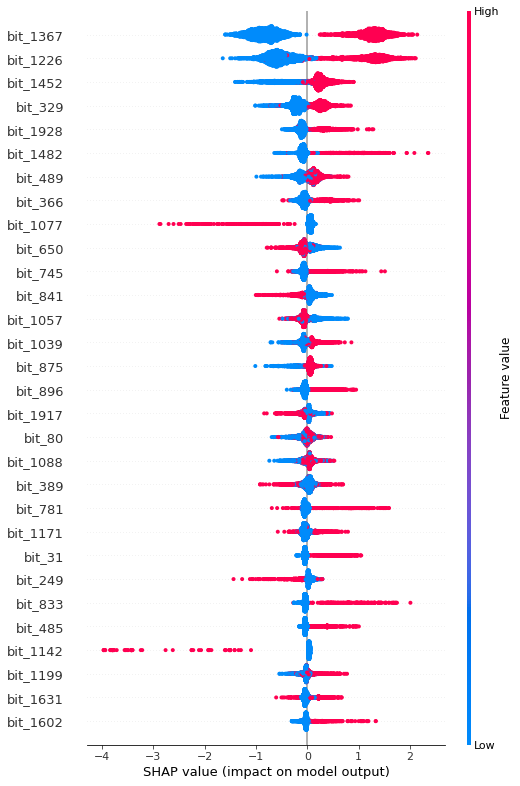

In [10]:
# nummary_plot explaining target class at index 0
shap.summary_plot(shap_explanation, train_X, max_display=30)

### Bar plot
Summarize the effects of features accross all instances

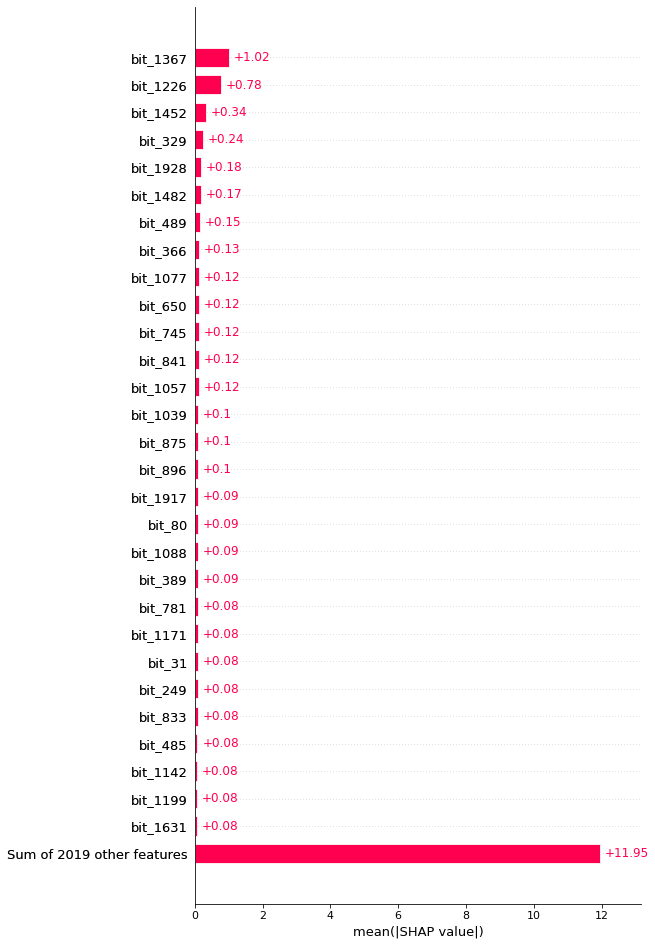

In [11]:
shap.plots.bar(shap_explanation, max_display=30)

As expected from ensembles (specially boosted trees), feature contributions "add up" to get a prediction result. Hence, the overall contribution of each feature tends to be small, and spread across many of them. However, in this scenario we clearly have two features standind out.

In [14]:
get_top_bits(shap_explanation.values, n=10)

[1367, 1226, 1452, 329, 1928, 1482, 489, 366, 1077, 650]

# Select top _N_ features using model performance as goal

    work in progress ...